# Train and evaluate NB model on case 14

- Load data
- process data
- train model
    - save model
- load test data
- run inference
- evaluate

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
os.chdir('..')
os.getcwd()

'/home/denny/Documents/mids/w266_NLP/lit-shazam'

In [5]:
from src.data.make_dataset import convert_examples_to_bag_of_words

[nltk_data] Downloading package punkt to /home/denny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1 Load training data

In [4]:
train_df = pd.read_parquet('./data/processed/train_bal_case14.parquet')
train_df.head()

,Train Data,Train Label
0,"It was from Charley, who had been sent by Cap...",2
1,"""Bacon bun?"" ""Why--yes."" He munched four of th...",0
2,"""Well, what's it about?"" Mr. Weatherbee's voic...",0
3,I did not think Mrs. Gardiner was so little t...,4
4,It may be very inconvenient some years to spar...,4


## Process Training data

In [24]:
# #########################################
# DEVELOP spaCy MODELS
# #########################################
!pip install spacy --quiet
!python -m spacy download en_core_web_sm

import spacy

nlp = spacy.load("en_core_web_sm")
spacy_limit = 1000000

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.4 MB/s eta 0:00:00m eta 0:00:010:0101
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [25]:
# ##############################################################################
# Use spacy to find and replace person names
#
# keep
#    0: find name and remove
#    1: replace name and keep 
#
# replace
#    text to replace name with
# ##############################################################################
def perform_NER(text, keep = True, replace = 'PERSON'):
    modified_tokens = []
    
    doc = nlp(text)
    for token in doc:
        #print(token.text)
        #print(token.ent_type_)
        if token.ent_type_ == 'PERSON': #in ('PERSON'):  # 'GPE', 'WORK_OF_ART'
            if (keep):
                modified_tokens.append(replace + token.whitespace_)
        else:
            #print(token.text)
            modified_tokens.append(token.text_with_ws)
            #print(modified_tokens)
    doc_wo_names = ''.join(modified_tokens)
    #print(doc_wo_names)
    return(doc_wo_names)

def get_NER_data(df_data, keep = True, replace = 'PERSON'):
    data  = []
    label = []
    
    for indx, row in df_data.iterrows():
        data.append(perform_NER(row[0], keep=keep, replace=replace))
        #data.append(row[0])
        label.append(row[1])
        
    return (data,label)

# Without using NER
def get_data(df_data):
    data  = []
    label = []
    
    for indx, row in df_train.iterrows():
        data.append(row[0])
        label.append(row[1])
        
    return (data,label)

In [28]:
train_data, train_label = get_NER_data(train_df, keep=False)
# test_data, test_label = get_NER_data(df_test, keep=False)
# train_data.head()

/tmp/ipykernel_578870/3837697101.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data.append(perform_NER(row[0], keep=keep, replace=replace))
/tmp/ipykernel_578870/3837697101.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label.append(row[1])


In [30]:
type(train_data)
train_data[:2]

['It was from  , who had been sent by Captain Vye to inquire if anything had  been heard of . The girl who admitted him looked in his face as  if she did not know what answer to return, and showed him in to where  was seated, saying to the reddleman, “Will you tell him, please?”    told. ’s only utterance was a feeble, indistinct sound.',
 '"Bacon bun?" "Why--yes." He munched four of these, finding them of pleasing savor, and then  consumed another double-chocolate jigger before ease descended upon him.']

In [31]:
# process the same as baseline models
# 0. NER
# 1. tokenize
# 2. stem
train_processed_examples = convert_examples_to_bag_of_words(train_data)
# train_labels = list(train_df['Train Label'])

In [32]:
print('Number of test examples: ', len(train_processed_examples))
len(train_processed_examples) == len(train_labels)

Number of test examples:  5775


True

## Train Naive Bayes Model

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer_params = dict()
mnb_params = dict()

nb_pipeline = Pipeline(
[
    ("vect", CountVectorizer(**vectorizer_params)),
    ("clf", MultinomialNB(**mnb_params)),
])

In [34]:
nb_pipeline.fit(train_processed_examples,train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

In [12]:
### Save model TODO

## Load test data

In [13]:
test_df = pd.read_parquet('./data/processed/test_case14.parquet')
test_df.head()

,Test Data,Test Label
0,I’d hate to have him get anything on me.” T...,0
1,“On wine?” “Why not?” “It’s the humidity...,1
2,The old rascal!—he said Elizabeth-Jane had die...,2
3,I feel for him sincerely.” A few minutes mo...,4
4,Then the greater right I have on my side when ...,3


In [35]:
test_data, test_label = get_NER_data(test_df, keep=False)
test_processed_examples = convert_examples_to_bag_of_words(test_data)

/tmp/ipykernel_578870/3837697101.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data.append(perform_NER(row[0], keep=keep, replace=replace))
/tmp/ipykernel_578870/3837697101.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label.append(row[1])


In [36]:
print('Number of test examples: ', len(test_processed_examples))
len(test_processed_examples) == len(test_labels)

Number of test examples:  3674


True

## Run Inference

In [37]:
y_nbf = nb_pipeline.predict(test_processed_examples)
y_nbf_pred_probs = nb_pipeline.predict_proba(test_processed_examples)
y_nbf[0:5]

array([2, 1, 2, 4, 4])

## Evaluate

In [38]:
# import evaluation metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, \
precision_score, precision_recall_curve, recall_score, roc_auc_score

              precision    recall  f1-score   support

  Fitzgerald       0.94      0.55      0.70       533
   Hemingway       0.76      0.83      0.80       306
     Dickens       0.77      0.71      0.74       611
       Hardy       0.79      0.72      0.76       940
      Austen       0.59      0.96      0.73       483
  Chesterton       0.68      0.83      0.75       337
 Shakespeare       0.97      0.88      0.92       464

    accuracy                           0.76      3674
   macro avg       0.79      0.78      0.77      3674
weighted avg       0.79      0.76      0.76      3674

------------------------------------------------------------



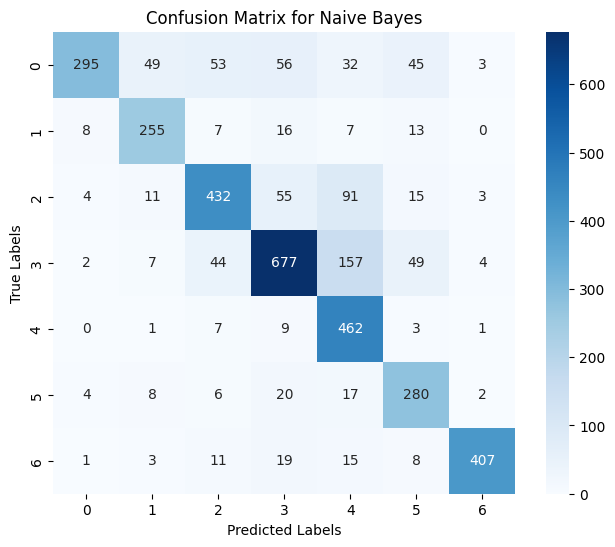

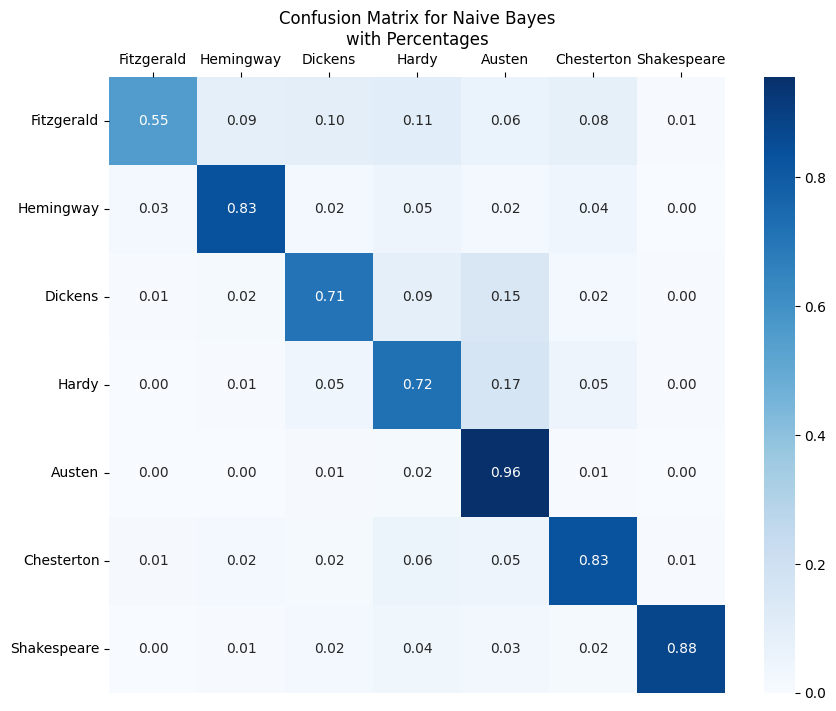

In [39]:
def eval_model(model_name, y_true, y_pred, y_pred_probas, conf_matrix):
    """perform standardized model evaluation
    prints metrics and plots to determine classification performance 
    TODO: returns a dictionary/dataframe of the metrics"""
    
    # TODO: change to load from dictionary
    class_labels = ["Fitzgerald", "Hemingway", "Dickens", "Hardy", "Austen", "Chesterton", "Shakespeare"]

    # print classification report
    print(classification_report(y_true, y_pred, target_names=class_labels))
    print("-" * 60)
    print()

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", square=True, xticklabels=True, yticklabels=True)
    # Set row labels
    
    plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")

    # Add a title
    plt.title(f"Confusion Matrix for {model_name}\nwith Percentages")
    plt.show()    
    
    # return metrics
    precision = precision_score(y_true, y_pred, average="micro" )
    recall = recall_score(y_true, y_pred, average="micro")
    f1 = f1_score(y_true, y_pred, average="micro") # same as accuracy
    roc_auc = roc_auc_score(y_true, y_pred_probas, average="micro", multi_class="ovr")

    #     ----------------------------------
    #     model_name | f1 score | precision | recall | roc_auc
    metrics_df = pd.DataFrame(data={'f1_score':f1, 
                               'precision':precision, 'recall':recall, 'roc_auc':roc_auc},
                             index=[model_name])
    return metrics_df

nb_metrics = eval_model('Naive Bayes', test_labels, y_nbf, y_nbf_pred_probs, confusion_matrix(test_labels, y_nbf))